# Calculate the feedbacks in single model abrupt-4xCO2 experiment by using the radiatvie kernel 

>ref: [Soden, et.al., (2008)](https://doi.org/10.1175/2007JCLI2110.1)


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import subprocess
# import numba
# from numba import njit
import time
sstart_time0 = time.time()

In [2]:
# # download r3k functions on the fly from github
# # comment this line if you manually downloaded it
# ! wget https://raw.githubusercontent.com/ChenggongWang/Radiative_Response_with_Radiative_Kernel/main/Radiative_Repsonse_with_Raditive_kernel.py -O Radiative_Repsonse_with_Raditive_kernel.py

In [3]:
# import the function as r3k 
import Radiative_Repsonse_with_Raditive_kernel as r3k
r3k.compile_njit_functions()

@njit Functions compiling ...  | finished!


# Data required and preprocess


- 8 Month mean variables [CMIP6 standard output](https://pcmdi.llnl.gov/mips/cmip3/variableList.html): 
`ta, hus, ts, rlut, rsdt, rsut, rsutcs, rlutcs`

- Control (12 month climatology) and Perturbation (nx12 monthly data) data are need.
If you have already computed anormaly data, create a control data filled with zeros
- `ta` and `hus` are 4d `(time, plev, lat, lon)` variables, while others are 3d `(time, lat, lon)` variables.
`time` should be nx12 month (n years >= 1 year). 

__Since data and kernel are discrete, we need regrid them to the same resolution.__
My practice: bring(regrid) the data to kernels.

## Download example data (4GB)
1. GFDL kernel file
2. GFDL-CM4 piControl
3. 4xCO2 experiment

> from: https://drive.google.com/drive/folders/1wtsZ4-kRXmNe2MXb2-czs4osTKASGa0x?usp=sharing
>
> or: https://tigress-web.princeton.edu/~cw55/share_data/r3k_example_data.tar (extract files: tar -xf xxx.tar)
>
> make sure data and kernel in path: ./data/

In [4]:
# this is for example data
# create your own function for your data
def read_postprocessed_data_example():
    var_list = 'ta hus ts rlut rsdt rsut rlutcs rsutcs rsus rsds'.split()
    var_cont = {}    # control data in dictionary {var: xarray,...}
    for var in var_list:
        filepath = f"./data/piControl/GFDL-CM4/{var}.mon.0001-0200.ltm.nc.r1i1p1f1.2x2.5.2021052021"
        var_cont[var] =  xr.open_dataset(filepath)[var].isel(model=0).load() # load into memory
    var_pert = {}    # perturbation data in dictionary {var: xarray,...}
    for var in var_list:
        filepath = f"./data/abrupt-4xCO2/GFDL-CM4/{var}.mon.0001-0150.nc.r1i1p1f1.2x2.5.2021052021"
        var_pert[var] =  xr.open_dataset(filepath)[var].isel(model=0).load() # load into memory
    return var_cont, var_pert 

def read_kernel_file(rk_source='GFDL'):
    rkpath = "./data/kernels_TOA_"+rk_source+"_CMIP6-standard.nc"
    f_RK =  xr.open_dataset(rkpath,decode_times=False) 
    if rk_source =='GFDL':
        f_RK =  f_RK.rename({'time': 'month'})
        f_RK.coords['month'] = np.arange(1,13,1)
    try:
        f_RK.coords['plev'].attrs['units'] 
    except:
        raise Exception("Error: please check plev or its units")
    return f_RK

In [5]:
%%time
# read data
f_RK =  read_kernel_file()
var_cont, var_pert = read_postprocessed_data_example()

CPU times: user 143 ms, sys: 1.63 s, total: 1.77 s
Wall time: 2.15 s


In [6]:
%%time
# compute RR with RK
ds_rk =  r3k.decompose_dR_rk_toa_core(var_pert, var_cont,f_RK )

CPU times: user 1min 12s, sys: 3.74 s, total: 1min 16s
Wall time: 8.74 s


# Plot section

In [8]:
   
def global_mean_xarray_nan(ds_XLL):
    """
    A function to compute the global mean value of the data.
    The data has to have the lat and lon in its dimensions.
    
    Parameters
    ----------
    ds_XLL   :  DataArray with lat and lon. ds_XLL.lat will be 
                used for area weight.

    Returns
    ----------
    GM_mean  : global mean value.
    
    """
    lat = ds_XLL.coords['lat']        # readin lat
    weight_area = np.cos(np.deg2rad(lat))
    data_XLL_weighted = (ds_XLL*weight_area).mean(dim=['lat','lon'])
    data_ones_nan = xr.where(np.isfinite(ds_XLL),1.,np.nan)
    weight_sum = (data_ones_nan*weight_area).mean(dim=['lat','lon'])
    GM_mean = data_XLL_weighted/weight_sum
    
    return GM_mean

In [9]:
dR_temp_gm = global_mean_xarray_nan(ds_write['dR_Ta']+ds_write['dR_Ts']).groupby('time.year').mean()
dR_clou_gm = global_mean_xarray_nan(ds_write['dR_c_lw']+ds_write['dR_c_sw']).groupby('time.year').mean()
dR_wv_gm = global_mean_xarray_nan(ds_write['dR_wv_lw']+ds_write['dR_wv_sw']).groupby('time.year').mean()
dR_albe_gm = global_mean_xarray_nan(ds_write['dR_alb']).groupby('time.year').mean()
dts_gm = global_mean_xarray_nan(ds_write['dts']).groupby('time.year').mean()

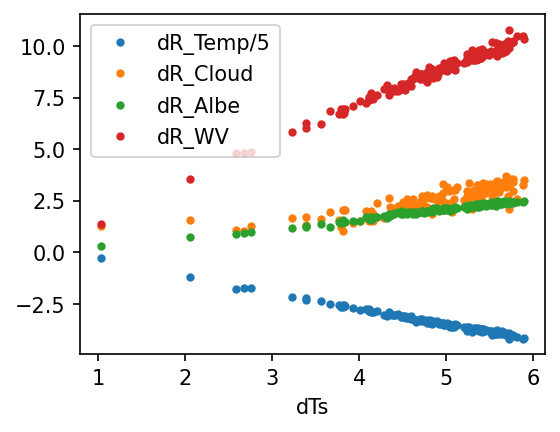

In [10]:
plt.close()
fig0 = plt.figure(figsize=(4,3),dpi=150)
ax1   = fig0.add_subplot(111)
ax1.plot(dts_gm,dR_temp_gm/5,'.',label='dR_Temp/5')
ax1.plot(dts_gm,dR_clou_gm,'.',label='dR_Cloud')
ax1.plot(dts_gm,dR_albe_gm,'.',label='dR_Albe')
ax1.plot(dts_gm,dR_wv_gm,'.',label='dR_WV')
ax1.set_xlabel('dTs')
plt.legend()
plt.show()